# Theory: PSI
Population stability index (PSI) is a statistic that measures how much a variable has shifted over time. The general idea is to compare production data to a baseline. The baseline values can be taken from either the training or validation datasets, but it is recommended to use the validation dataset only if the problem is too volatile. PSI can be calculated using the following formula:

$$
\text{PSI} = \sum_{i=1}^{n} (A_i - E_i) \cdot \ln\left(\frac{A_i}{E_i}\right)
$$
where:
- $n$ is the number of bins,
- $A_i$ is the actual percentage of observations in the $i$-th bin of the test (current) dataset,
- $E_i$ is the expected percentage of observations in the $i$-th bin of the reference (training) dataset.

### Steps to Calculate PSI:
1. **Divide** the range of the variable into bins.
2. **Calculate** the percentage of observations in each bin for both the test (current) dataset and the reference (training) dataset.
3. **Compute** the PSI using the formula above by summing the contributions of all bins.

### Interpretation of PSI Values (Rule of Thumb):
- **PSI < 0.1**: No significant population change.
- **0.1 ≤ PSI < 0.25**: Moderate population change.
- **PSI ≥ 0.25**: Significant population change.

### Example Calculation:
If you have the following distributions for a variable:

| Bin | Percentage in Training Dataset (\( E_i \)) | Percentage in Current Dataset (\( A_i \)) |
|-----|------------------------------------------|----------------------------------------|
| 1   | 20%                                      | 15%                                    |
| 2   | 30%                                      | 25%                                    |
| 3   | 25%                                      | 35%                                    |
| 4   | 25%                                      | 25%                                    |

The PSI would be calculated as follows:
$$
\text{PSI} = \sum_{i=1}^{4} (A_i - E_i) \cdot \ln\left(\frac{A_i}{E_i}\right)
$$
$$
 \text{PSI} = (0.15 - 0.20) \cdot \ln\left(\frac{0.15}{0.20}\right) + (0.25 - 0.30) \cdot \ln\left(\frac{0.25}{0.30}\right) + (0.35 - 0.25) \cdot \ln\left(\frac{0.35}{0.25}\right) + (0.25 - 0.25) \cdot \ln\left(\frac{0.25}{0.25}\right)
$$
You can then compute these terms and sum them up to get the final PSI value.

# Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(1, '../scripts')
from psi_calculation import psi, kl_divergence
from binning_techiniques import quantile_binning, equal_width_binning, median_centered_binning

In [2]:
DATA_PATH = "../data"
df_train = pd.read_csv(f"{DATA_PATH}/train_preprocessed.csv")
df_normalized = pd.read_csv(f"{DATA_PATH}/train_preprocessed_normalized.csv")

## Visualization of "Weekly Cases" Before x After Vaccine in Brazil

In [3]:
baseline = df_train.loc[(df_train["Location"]=="Brazil") & (df_train["After Vaccine"] == False), "Weekly Cases"].dropna()
production = df_train.loc[(df_train["Location"]=="Brazil") & (df_train["After Vaccine"] == True), "Weekly Cases"].dropna()
len(baseline), len(production)

(248, 370)

Text(0.5, 1.0, 'Before vs After')

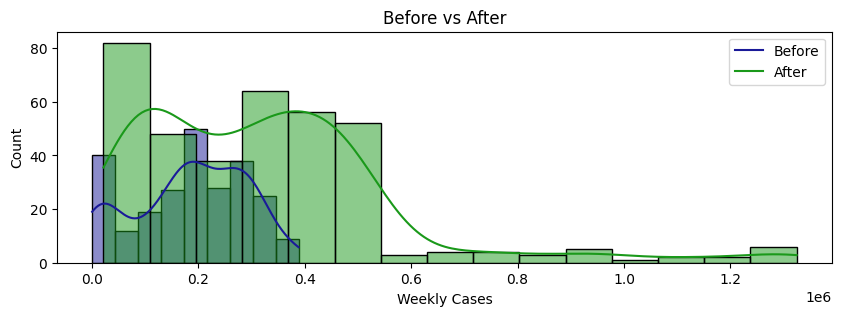

In [4]:
plt.figure(figsize = (10,3))
sns.histplot(baseline, kde = True, color = (0.1, 0.1, 0.6))
sns.histplot(production, kde = True, color = (0.1, 0.6, 0.1))
plt.legend(["Before", "After"])
plt.title("Before vs After")

## Calculating PSI

/var/folders/sd/rjwvv_616xz49rxkpk2gfxxc0000gn/T/ipykernel_82383/3361914770.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


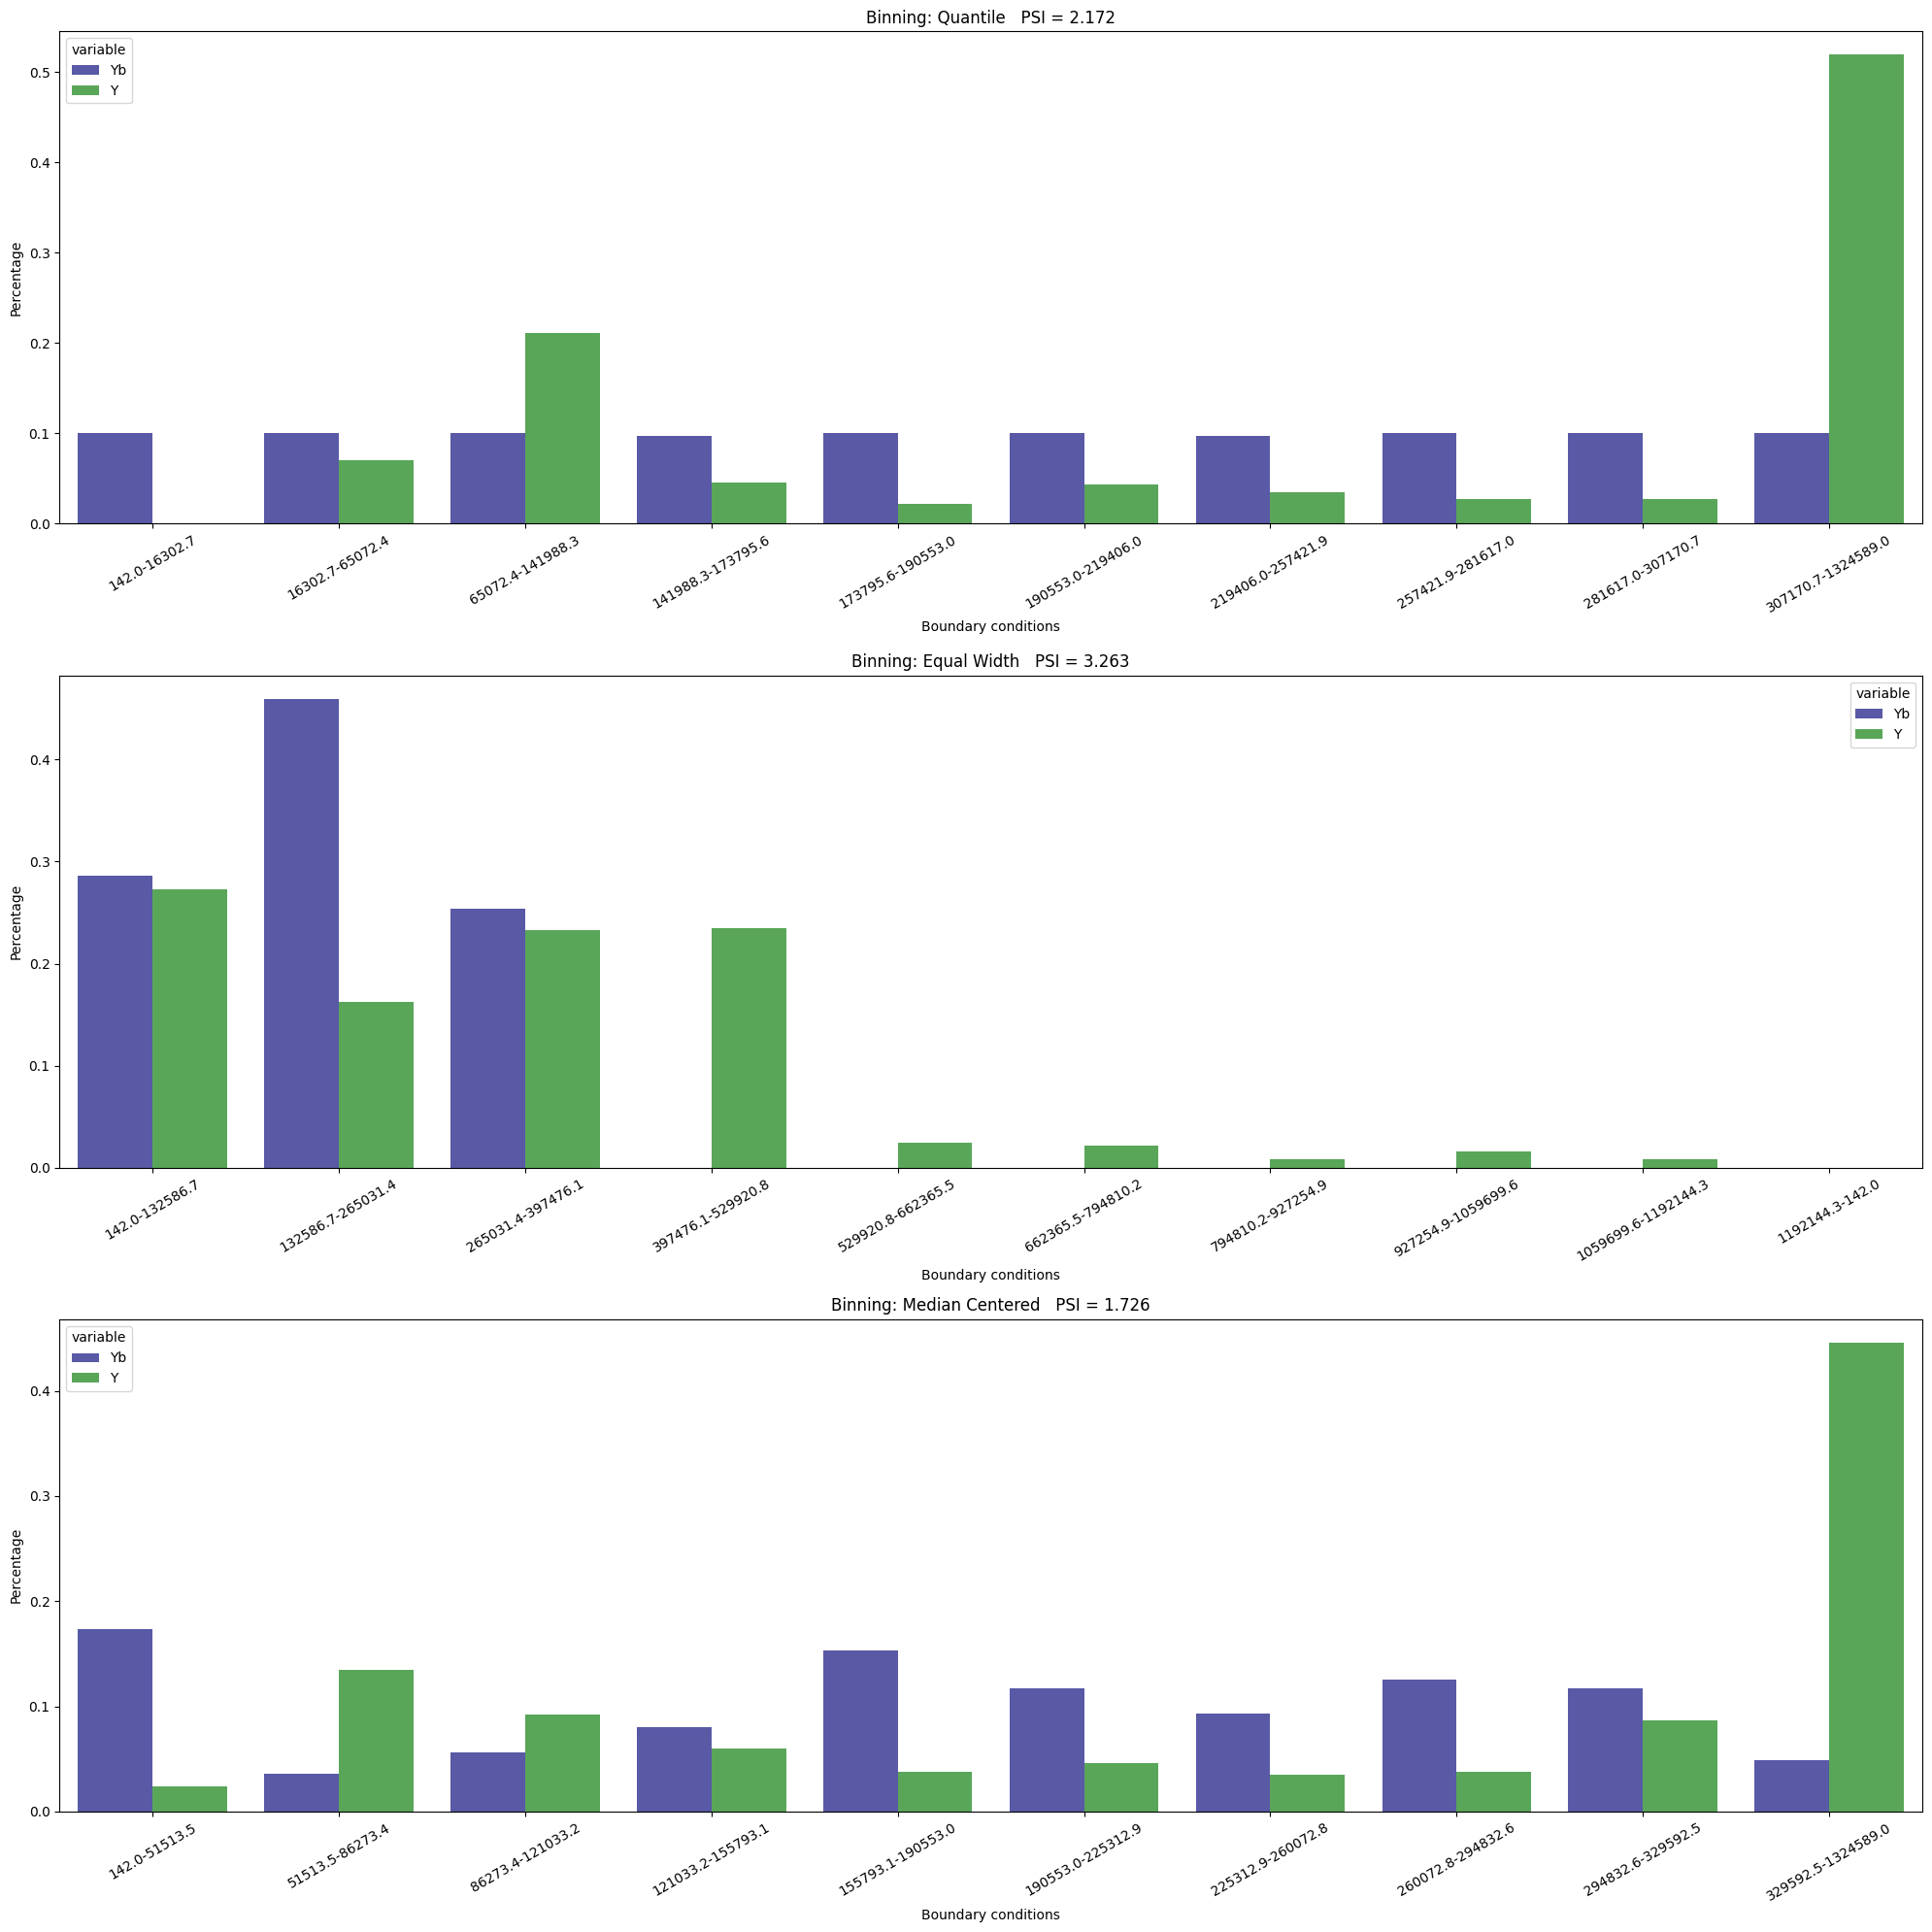

In [5]:
bins_methods = [
    quantile_binning(baseline, production),
    equal_width_binning(baseline, production),
    median_centered_binning(baseline, production)
]

method = ["Quantile", "Equal Width", "Median Centered"]

fig, axes = plt.subplots(3,1, figsize=(20, 20), constrained_layout=True)

for i, bins in enumerate(bins_methods):

    df = pd.DataFrame.from_dict(psi(baseline, production, bins=bins))

    axes[i].set_title(f"Binning: {method[i]}   PSI = {sum(df['PSI']):.3f}")

    ax = sns.barplot(
        pd.melt(df.drop(columns="PSI"), id_vars="Boundary conditions", value_name="Percentage"),
        x="Boundary conditions",
        y="Percentage",
        hue="variable",
        palette=[(0.3, 0.3, 0.7), (0.3, .7, 0.3)],
        ax=axes[i]
    )
    ax.tick_params(axis='x', labelrotation=30)
fig.tight_layout()
plt.show()

## For the normalized dataset

In [6]:
baseline = df_normalized.loc[(df_normalized["Location"]=="Brazil") & (df_normalized["After Vaccine"] == False), "Weekly Cases"].dropna()
production = df_normalized.loc[(df_normalized["Location"]=="Brazil") & (df_normalized["After Vaccine"] == True), "Weekly Cases"].dropna()
len(baseline), len(production)

(248, 370)

Text(0.5, 1.0, 'Before vs After')

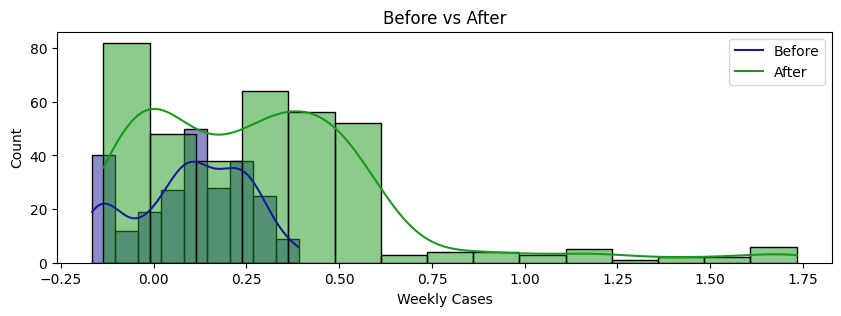

In [7]:
plt.figure(figsize = (10,3))
sns.histplot(baseline, kde = True, color = (0.1, 0.1, 0.6))
sns.histplot(production, kde = True, color = (0.1, 0.6, 0.1))
plt.legend(["Before", "After"])
plt.title("Before vs After")

### Calculating PSI

/var/folders/sd/rjwvv_616xz49rxkpk2gfxxc0000gn/T/ipykernel_82383/3361914770.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


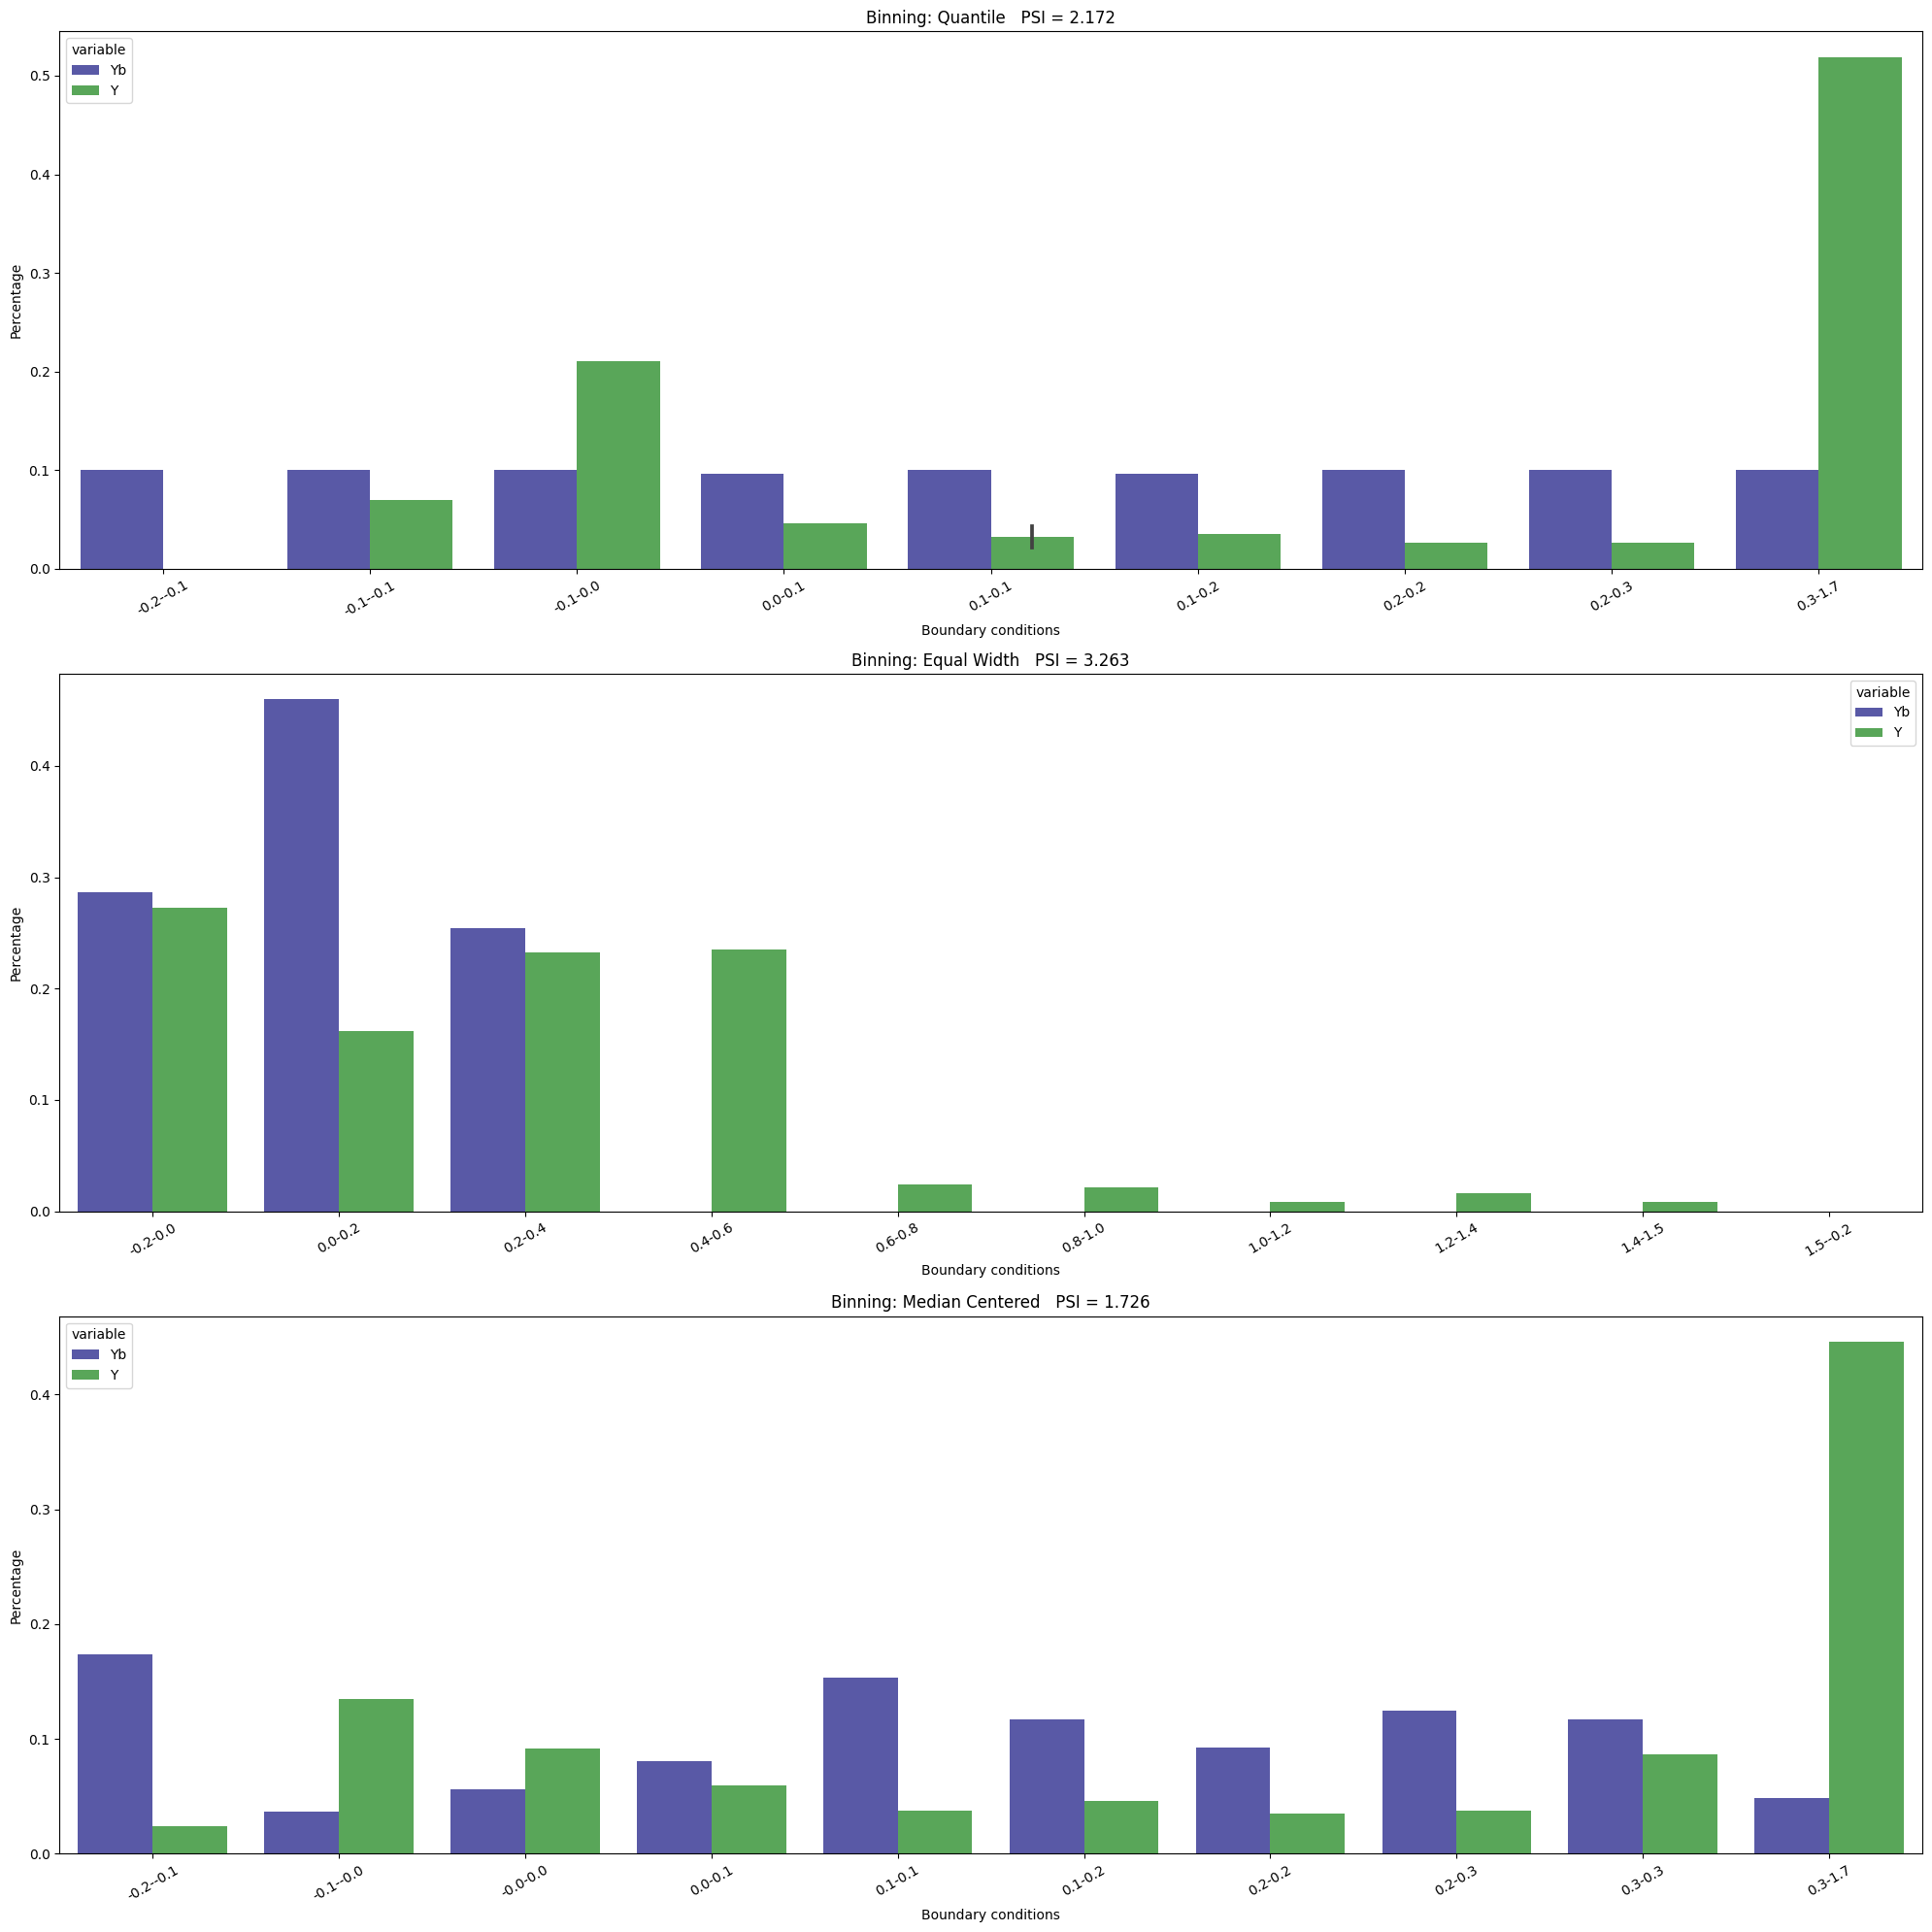

In [8]:
bins_methods = [
    quantile_binning(baseline, production),
    equal_width_binning(baseline, production),
    median_centered_binning(baseline, production)
]

method = ["Quantile", "Equal Width", "Median Centered"]

fig, axes = plt.subplots(3,1, figsize=(20, 20), constrained_layout=True)

for i, bins in enumerate(bins_methods):

    df = pd.DataFrame.from_dict(psi(baseline, production, bins=bins))

    axes[i].set_title(f"Binning: {method[i]}   PSI = {sum(df['PSI']):.3f}")

    ax = sns.barplot(
        pd.melt(df.drop(columns="PSI"), id_vars="Boundary conditions", value_name="Percentage"),
        x="Boundary conditions",
        y="Percentage",
        hue="variable",
        palette=[(0.3, 0.3, 0.7), (0.3, .7, 0.3)],
        ax=axes[i]
    )
    ax.tick_params(axis='x', labelrotation=30)
fig.tight_layout()
plt.show()

# Theory: KL-divergence

KL-divergence is a asymmetric version of PSI. Its formula is: 

$$
D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \left( \frac{P(i)}{Q(i)} \right) 
$$

Where:
- $ D_{KL}(P \parallel Q)$: is the KL-Divergence from  $Q$ to $P$.
- $ P $ and $ Q $ are the two probability distributions.
- $ P(i) $ and $ Q(i) $ are the probabilities of the $ i $-th event in distributions $ P $ and $ Q $, respectively.
- $ p(x) $ and $ q(x) $ are the probability density functions of the continuous distributions $ P $ and $ Q $, respectively.

Since it is asymetric: 

$$ D_{KL}(P \parallel Q) \neq D_{KL}(Q \parallel P) $$

PSI can be writen as:

$$ PSI = D_{KL}(P \parallel Q) + D_{KL}(Q \parallel P) $$

So it is a symetric version of KL-divergence.

## Visualization of "Weekly Cases" Before x After Vaccine in Brazil

In [9]:
baseline = df_train.loc[(df_train["Location"]=="Brazil") & (df_train["After Vaccine"] == False), "Weekly Cases"].dropna()
production = df_train.loc[(df_train["Location"]=="Brazil") & (df_train["After Vaccine"] == True), "Weekly Cases"].dropna()
len(baseline), len(production)

(248, 370)

Text(0.5, 1.0, 'Before vs After')

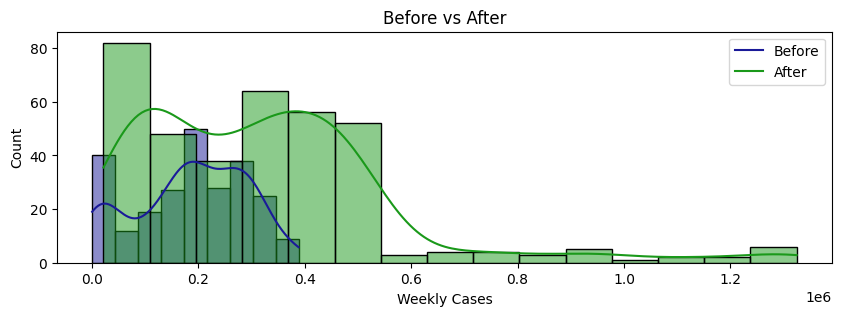

In [10]:
plt.figure(figsize = (10,3))
sns.histplot(baseline, kde = True, color = (0.1, 0.1, 0.6))
sns.histplot(production, kde = True, color = (0.1, 0.6, 0.1))
plt.legend(["Before", "After"])
plt.title("Before vs After")

## Calculating KL-divergence A/B

/var/folders/sd/rjwvv_616xz49rxkpk2gfxxc0000gn/T/ipykernel_82383/3164819515.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


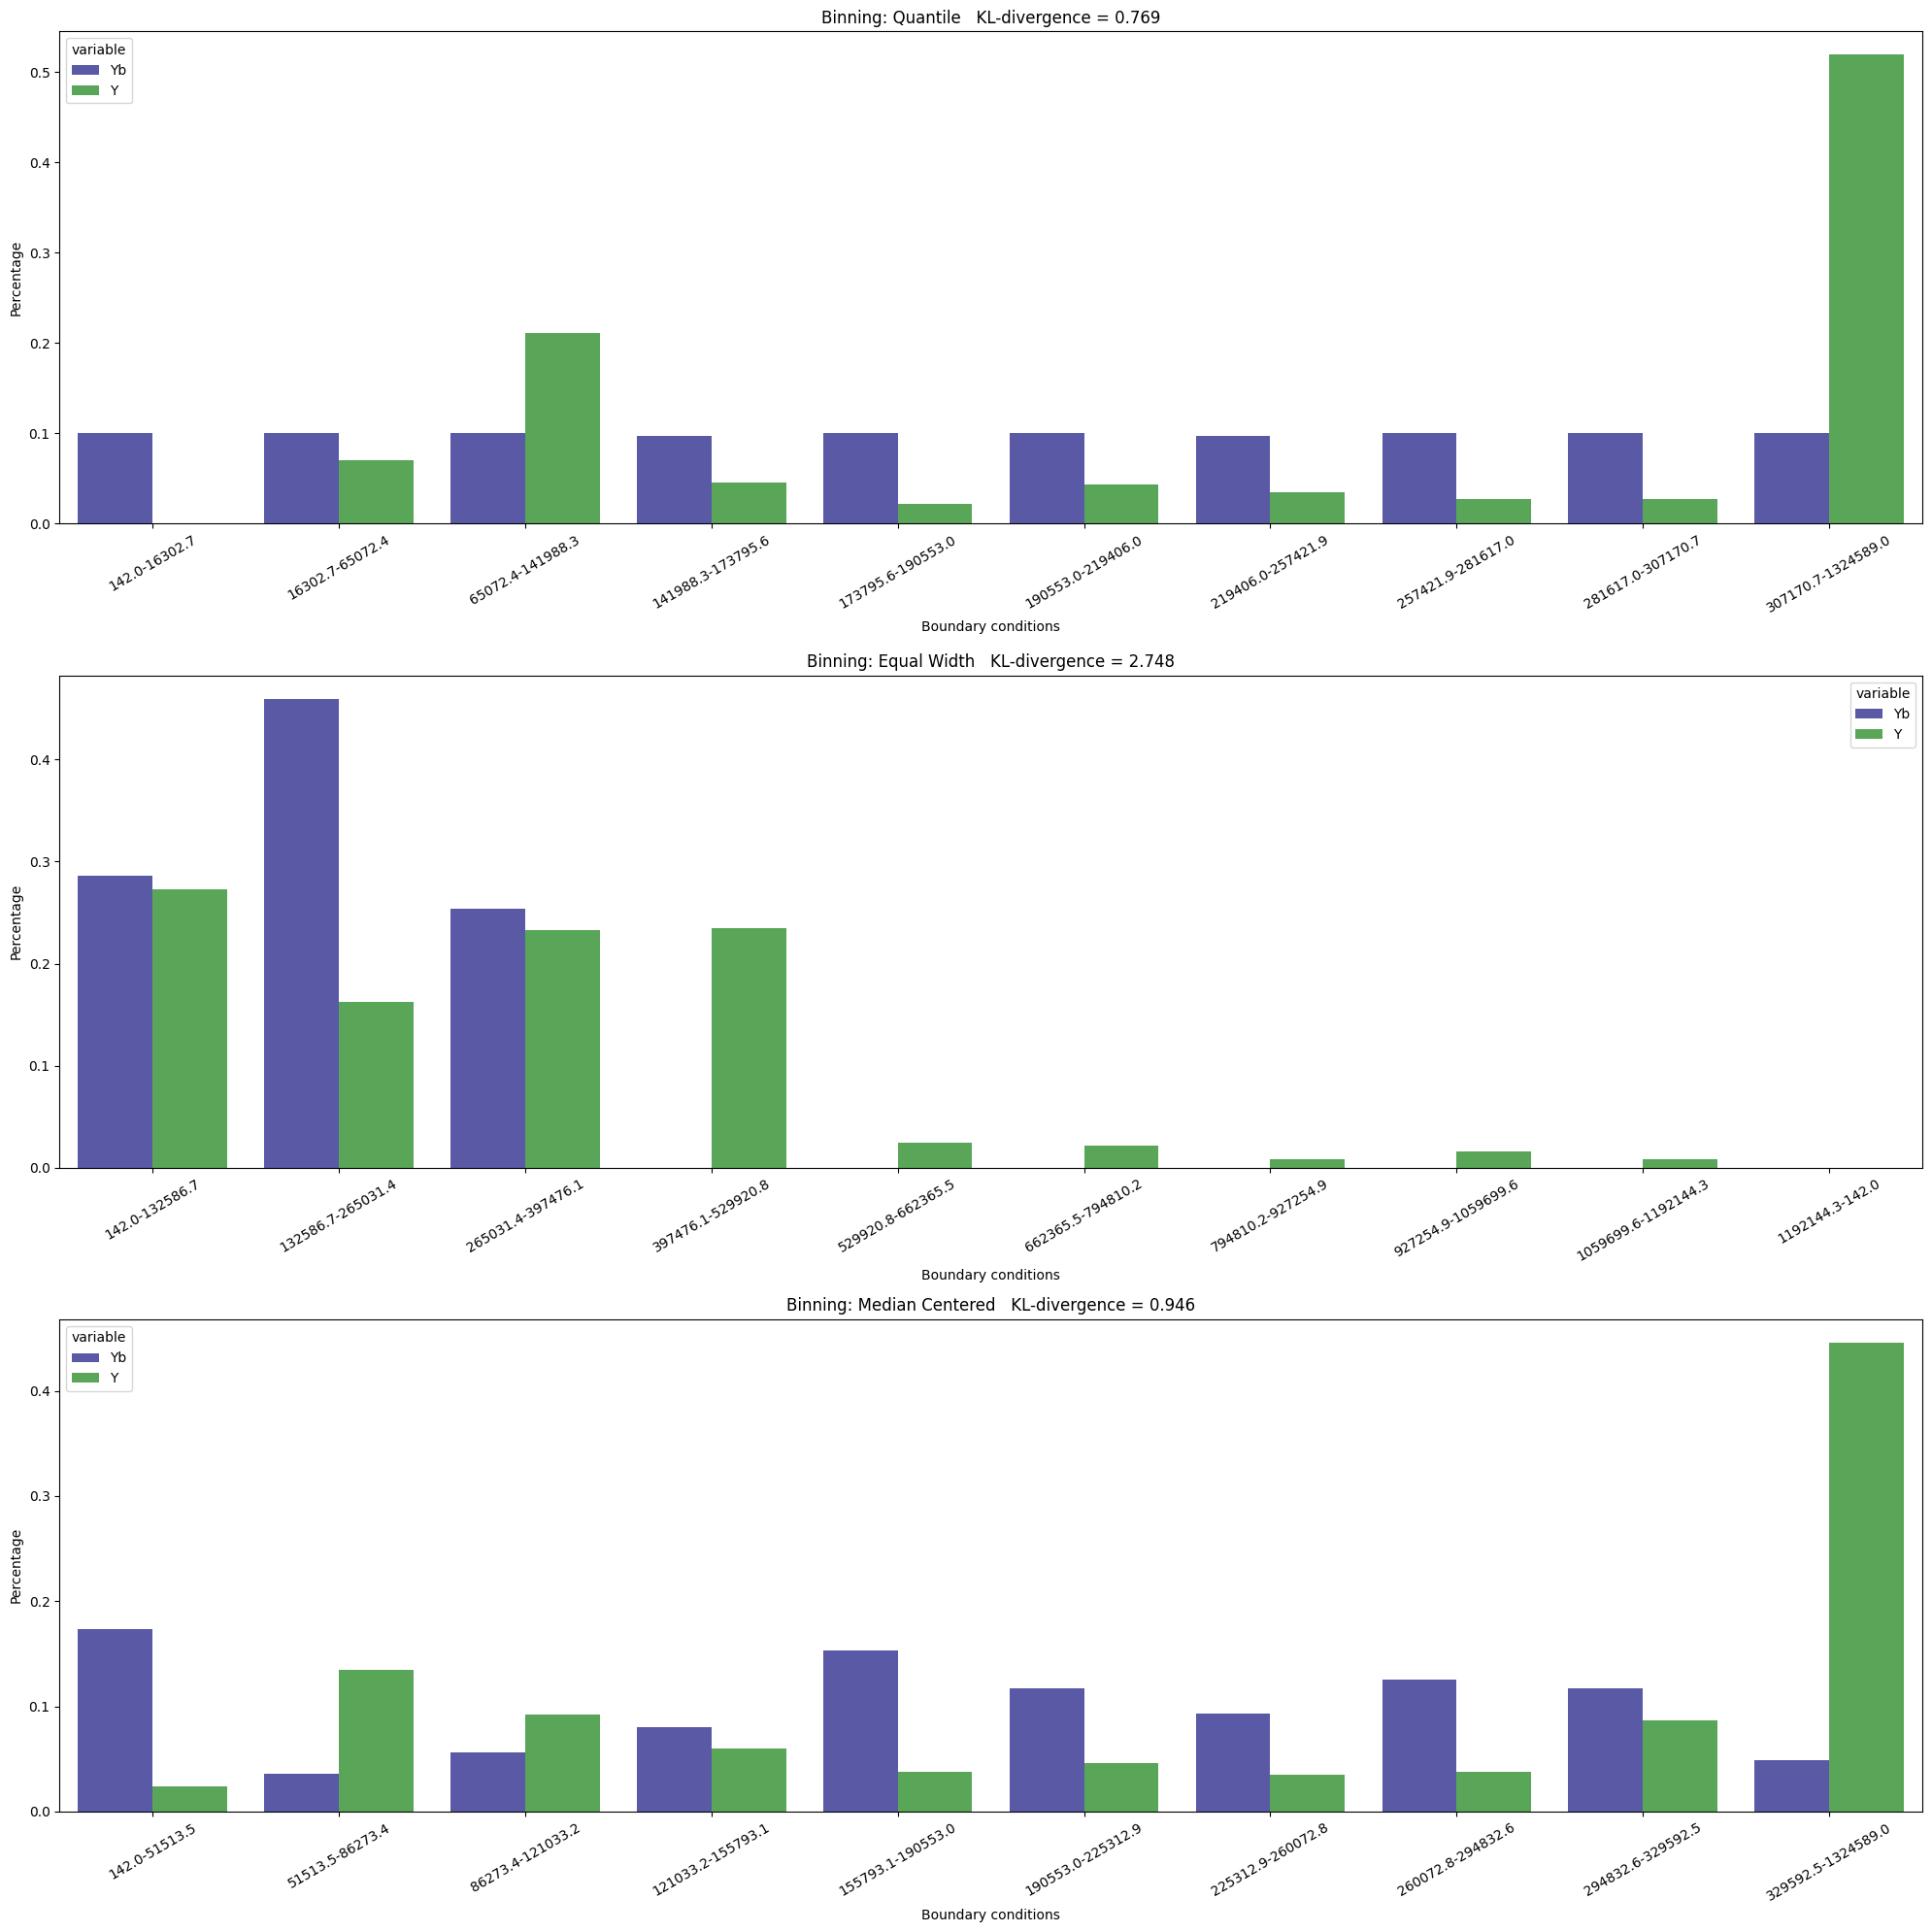

In [12]:
bins_methods = [
    quantile_binning(baseline, production),
    equal_width_binning(baseline, production),
    median_centered_binning(baseline, production)
]

method = ["Quantile", "Equal Width", "Median Centered"]

fig, axes = plt.subplots(3,1, figsize=(20, 20), constrained_layout=True)

for i, bins in enumerate(bins_methods):

    df = pd.DataFrame.from_dict(kl_divergence(baseline, production, bins=bins))

    axes[i].set_title(f"Binning: {method[i]}   KL-divergence = {sum(df['KL-divergence']):.3f}")

    ax = sns.barplot(
        pd.melt(df.drop(columns="KL-divergence"), id_vars="Boundary conditions", value_name="Percentage"),
        x="Boundary conditions",
        y="Percentage",
        hue="variable",
        palette=[(0.3, 0.3, 0.7), (0.3, .7, 0.3)],
        ax=axes[i]
    )
    ax.tick_params(axis='x', labelrotation=30)
fig.tight_layout()
plt.show()

## Calculating KL-divergence B/A

/var/folders/sd/rjwvv_616xz49rxkpk2gfxxc0000gn/T/ipykernel_82383/2116632090.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


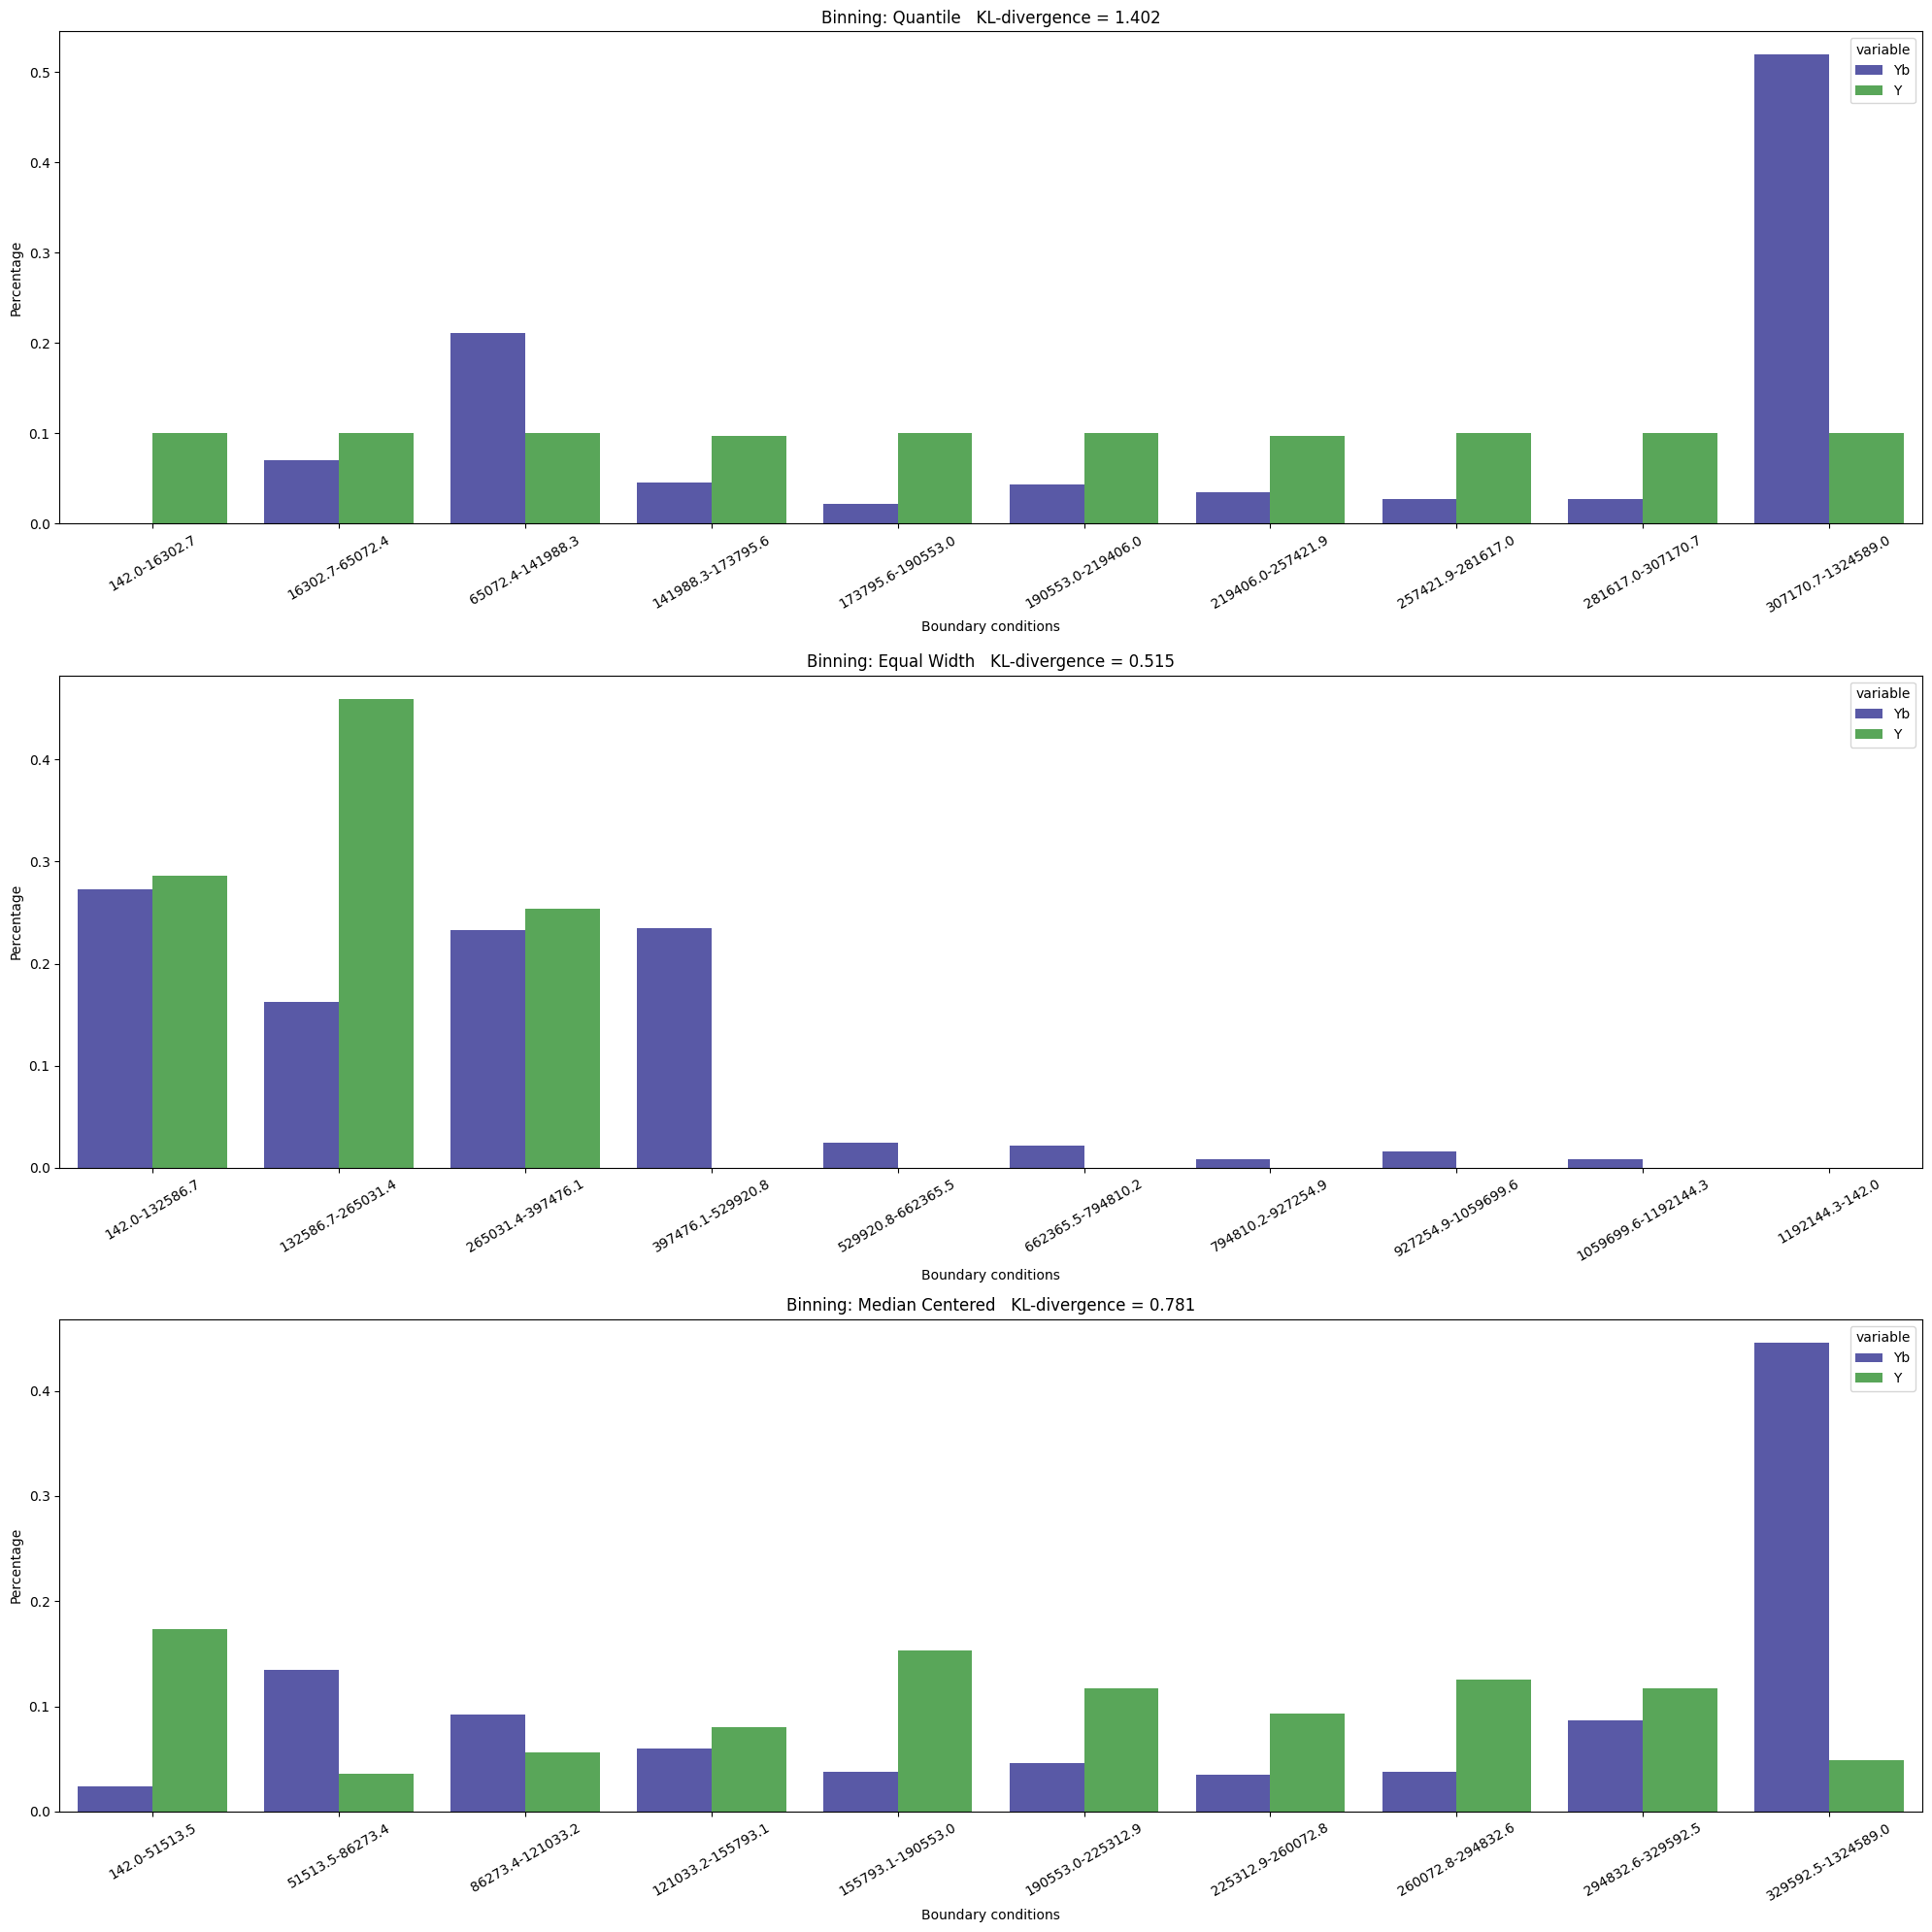

In [13]:
bins_methods = [
    quantile_binning(baseline, production),
    equal_width_binning(baseline, production),
    median_centered_binning(baseline, production)
]

method = ["Quantile", "Equal Width", "Median Centered"]

fig, axes = plt.subplots(3,1, figsize=(20, 20), constrained_layout=True)

for i, bins in enumerate(bins_methods):

    df = pd.DataFrame.from_dict(kl_divergence(production, baseline, bins=bins))

    axes[i].set_title(f"Binning: {method[i]}   KL-divergence = {sum(df['KL-divergence']):.3f}")

    ax = sns.barplot(
        pd.melt(df.drop(columns="KL-divergence"), id_vars="Boundary conditions", value_name="Percentage"),
        x="Boundary conditions",
        y="Percentage",
        hue="variable",
        palette=[(0.3, 0.3, 0.7), (0.3, .7, 0.3)],
        ax=axes[i]
    )
    ax.tick_params(axis='x', labelrotation=30)
fig.tight_layout()
plt.show()

As you can see, the values are different to when we calculate do A/B.